<a name="top"></a>
# Predicting Real/Fake News

## 1-Data-Acquisition-and-Cleaning
---
* [Problem Statement](#Problem-Statement)
* [Executive Summary](#Executive-Summary)
    * [Context](#Context)
    * [Scope](#Scope)
* [Data Dictionary](#Data-Dictionary)
* [Importing Libraries](#Importing-Libraries)
* [Data Acquisition](#Data-Acquisition)
    * [Data Merging](#Data-Merging)
* [Data Cleaning](#Data-Cleaning)
* [Saving Corpus](#Saving-Corpus)
  

## Problem Statement

**To predict real/fake news** based on a kaggle dataset containing various news sources within the US.

## Executive Summary

### Context

Fake news has risen dramatically in popular consciousness over the last few years. According to a Pew Research Center study, Americans deem fake news to be a larger problem than racism, climate change or terrorism. With the advent of social media and the amount of information accessible to us, it is getting increasingly difficult to distinguish between real news and fake news. Therefore, this could have severe repercussions within society if the problem is not dealt with. 

### Scope

The goal of this project was to come up with a model that distinguishes real and fake news using a kaggle data set that contains real news and fake news based on US news outlets. In order to tackle the problem of fake news, several classification models such as the Logistic Regression and Decision trees were applied. It is worth pointing out that the data set is limited in terms of its time frame where news was collated between 2015 and 2018 and also only based on US news outlets. However, the model that has been trained can certainly be helpful in other countries as well.

## Data Dictionary
|Feature|Type|Dataset|Description|
|---|---|---|---|
|title|object|true/fake kaggle|title of news article| 
|text|object|true/fake kaggle|content of the news|
|category|int|true/fake kaggle|"1" = true, "0" = fake (target variable)|

## Importing Libraries

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
import warnings
warnings.filterwarnings('ignore')
from bs4 import BeautifulSoup
import re,string,unicodedata
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
sns.set_style('ticks')
from nltk.corpus import stopwords
from string import punctuation
from nltk import pos_tag
import nltk
from nltk.util import ngrams
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

%matplotlib inline
from wordcloud import WordCloud
import datetime as dt

## Data Acquisition

In [2]:
true = pd.read_csv('../datasets/true.csv', parse_dates=True)
fake = pd.read_csv('../datasets/fake.csv', parse_dates=True)

In [3]:
# getting some basic information about each dataframe
# shape of dataframe i.e. number of rows and columns
# total number of rows with null values
# total number of duplicates
# data types of columns

def basic_eda(df, df_name):
    print(df_name.upper())
    print()
    print(f"Rows: {df.shape[0]} \t Columns: {df.shape[1]}")
    print()
    
    print(f"Total null rows: {df.isnull().sum().sum()}")
    print(f"Percentage null rows: {round(df.isnull().sum().sum() / df.shape[0] * 100, 2)}%")
    print()
    
    print(f"Total duplicate rows: {df[df.duplicated(keep=False)].shape[0]}")
    print(f"Percentage duplicate rows: {round(df[df.duplicated(keep=False)].shape[0] / df.shape[0] * 100, 2)}%")
    print()
    
    print(df.dtypes)
    print("______________________________\n")


In [4]:
dfs = [(true, 'true'),
    (fake, 'fake')]

In [5]:
[basic_eda(df, name) for df, name in dfs]

TRUE

Rows: 21417 	 Columns: 4

Total null rows: 0
Percentage null rows: 0.0%

Total duplicate rows: 399
Percentage duplicate rows: 1.86%

title      object
text       object
subject    object
date       object
dtype: object
______________________________

FAKE

Rows: 23481 	 Columns: 4

Total null rows: 0
Percentage null rows: 0.0%

Total duplicate rows: 6
Percentage duplicate rows: 0.03%

title      object
text       object
subject    object
date       object
dtype: object
______________________________



[None, None]

In [6]:
true.head(5)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


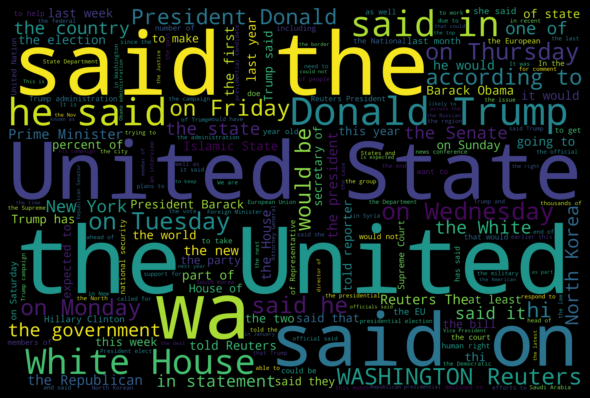

In [40]:
#Word Cloud
text = ''
for news in true.text.values:
    text += f" {news}"
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)
fig = plt.figure(
    figsize = (8, 8),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [7]:
fake.head(5)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


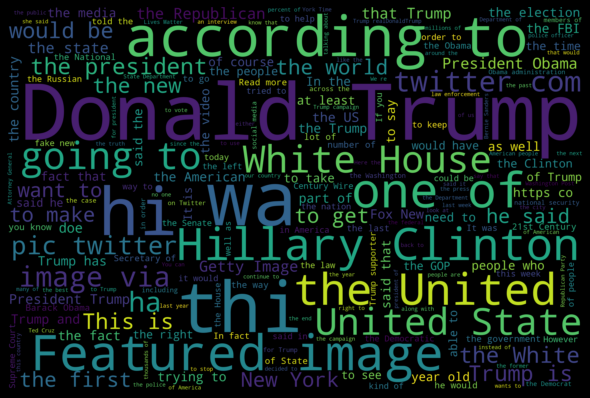

In [36]:
#Word Cloud
text = ''
for news in fake.text.values:
    text += f" {news}"
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)
fig = plt.figure(
    figsize = (8, 8),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
del text

### Data Merging

In [8]:
# Create new columns in both datasets in order to merge them 

true['category'] = 1
fake['category'] = 0

# Merge both data frames

df = pd.concat([true,fake])

In [9]:
df.head(5)

,title,text,subject,date,category
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


## Data Cleaning

In [10]:
# Check for null values

print(df.isna().sum())
print()

# check value counts of the subject (categorical variable)

print()
print(df.subject.value_counts())

title       0
text        0
subject     0
date        0
category    0
dtype: int64


politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64


In [11]:
messages = df.copy()

# reset index

messages.reset_index(inplace=True)


In [12]:
# Rename Columns
# "politicsNews" & "politics" will be combined under the new name --> "Politics"

messages.replace(to_replace ="politicsNews", 
                 value ="Politics", inplace=True)
messages.replace(to_replace ="worldnews", 
                 value ="World", inplace=True)
messages.replace(to_replace ="News", 
                 value ="News", inplace=True)
messages.replace(to_replace ="politics", 
                 value ="Politics", inplace=True)
messages.replace(to_replace ="left-news", 
                 value ="Left-leaning", inplace=True)
messages.replace(to_replace ="Government News", 
                 value ="Governmental", inplace=True)
messages.replace(to_replace ="US_News", 
                 value ="USA", inplace=True)
messages.replace(to_replace ="Middle-east", 
                 value ="Middle-East", inplace=True)

# Drop column "index"

messages.drop('index', axis=1, inplace=True)

In [13]:
# Change date column to be datetime dtype

messages['date'] = pd.to_datetime(messages['date'], errors='coerce')

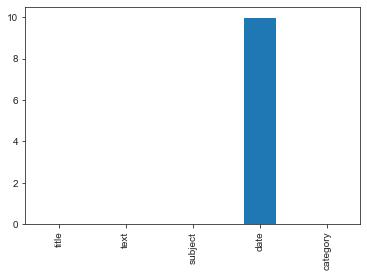

In [14]:
# Counting missing values after errors='coerce'

messages.isna().sum()

# Plotting missing values

messages.isna().sum().plot(kind='bar')
plt.show()

In [15]:
# Remove missing values

messages.dropna(inplace=True)

In [16]:
# Summarising dates

print(messages['date'].min())
print(messages['date'].max())

2015-03-31 00:00:00
2018-02-19 00:00:00


Politics        18108
World           10145
News             9050
Left-leaning     4456
Governmental     1568
USA               783
Middle-East       778
Name: subject, dtype: int64


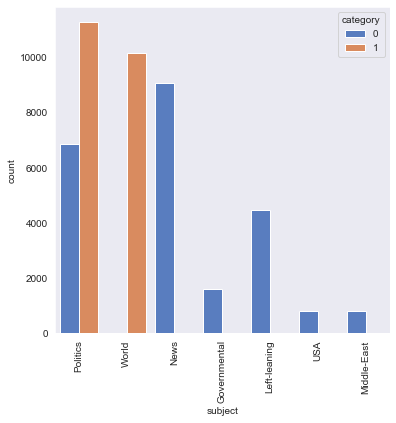

In [17]:
# Check for the number of topics within the 'subject' column

print(messages.subject.value_counts())

plt.figure(figsize = (6,6))
sns.set_style("dark")
chart = sns.countplot(x = "subject", hue = "category" , data = messages , palette = 'muted')
chart.set_xticklabels(chart.get_xticklabels(),rotation=90);

Subjects don't tell us anything useful and could be dropped.

In [18]:
# Delete column subject

del messages['subject']

In [19]:
display(messages.head())

,title,text,date,category
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,2017-12-31,1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,2017-12-29,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,2017-12-31,1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,2017-12-30,1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,2017-12-29,1


In [20]:
# People might also enter space twice accidentally, convert two spaces into a single space
def replace_multispace_w_space(x):
    return re.sub('([ ]{2,})',' ',x)

# map functions
messages['title'] = messages['title'].map(replace_multispace_w_space)
messages['text'] = messages['text'].map(replace_multispace_w_space)

In [21]:
# Apply a first round of text cleaning techniques
import re
import string

def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[‘’“”…]', '', text)
    return text

round1 = lambda x: clean_text_round1(x)

In [22]:
# Look at updated text
data_clean = pd.DataFrame(messages.text.apply(round1))
data_clean2 = pd.DataFrame(messages.title.apply(round1))

In [23]:
df = pd.concat([data_clean2, data_clean, messages['category'], messages['date']], axis=1)

In [24]:
# Drop date column

del df['date']

In [25]:
# Remove rows with missing values
df.dropna(inplace=True)

# Remove duplicates
df.drop_duplicates(inplace=True)

## Saving Corpus

In [26]:
# Get a sense of the cleaned data frame

display(df.head())
print(df.info())
print()
print(df.shape)

import pickle
df.to_pickle("corpus.pkl")

,title,text,category
0,as us budget fight looms republicans flip thei...,washington reuters the head of a conservative...,1
1,us military to accept transgender recruits on ...,washington reuters transgender people will be...,1
2,senior us republican senator let mr mueller do...,washington reuters the special counsel invest...,1
3,fbi russia probe helped by australian diplomat...,washington reuters trump campaign adviser geo...,1
4,trump wants postal service to charge much more...,seattlewashington reuters president donald tr...,1


<class 'pandas.core.frame.DataFrame'>
Int64Index: 39080 entries, 0 to 44119
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     39080 non-null  object
 1   text      39080 non-null  object
 2   category  39080 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.2+ MB
None

(39080, 3)
